In [1]:
""" Script for analysing single flyVR trials with optogenetic stimulation 
(assumes use of FlyOver version 9.4 or higher) """

__author__ = 'Hannah Haberkern, hjmhaberkern@gmail.com'

import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
    
from os import listdir, mkdir, walk
from os.path import isfile, sep
from sys import path, exit
from glob import glob

from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# Import custom plotting functions
path.insert(1, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import myAxisTheme, timeAxisTheme, niceScatterPlot, makeNestedPlotDirectory
from flyTracePlots import plotPosInRange
from velocityDistributionPlots import plotVeloHistogram_fancy, velocitySummaryPlot

# Import custom data processing functions
path.insert(1, '/Users/hannah/Dropbox/code/flyVR/utilities/')
from loadSingleTrial import loadSingleVRLogfile, rZoneParamsFromLogFile
from loadObjectCoords import loadObjectCoords
from objectInteractionPlots import modulationOfRuns,residencyWithHistograms_splitOnWalking, curvatureVsHeading_DistanceBoxplot, plotResidencyInMiniarena


path.insert(1, '/Users/hannah/Dropbox/code/trajectoryAnalysis/')
from downsample import donwsampleFOData
from trajectoryDerivedParams import convertRawHeadingAngle, velocityFromTrajectory, relationToObject, computeCurvature
from periodicWorldAnalysis import collapseToMiniArena

sns.set_style('ticks')


%matplotlib inline 

# Choose file to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver094/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
expDir = askdirectory(initialdir=baseDir, title='Select experiment directory of a single fly') + sep
dataDir = sep.join(expDir.split(sep)[0:-3]) + sep
flyID = expDir.split(sep)[-2]

FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
FODataFiles = sorted(FODataFiles)

print('\n Analysing the following log files:\n')
print(FODataFiles)


 Analysing the following log files:

['singleObjectForest_1cm4cmCone_12cmHex_HC-Gal4x20CsChrWTB_m04_7d_none_out_160122162302.txt', 'singleObjectForest_1cm4cmCone_12cmHex_HC-Gal4x20CsChrWTB_m04_7d_none_out_160122164742.txt', 'singleObjectForest_1cm4cmCone_12cmHex_HC-Gal4x20CsChrWTB_m04_7d_rZones_out_160122163452.txt', 'singleObjectForest_1cm4cmInvisibleCone_12cmHex_HC-Gal4x20CsChrWTB_m04_7d_rZones_out_160122161140.txt']


In [2]:
flyID = expDir.split(sep)[-2]
genotype = expDir.split(sep)[-5]
analysisDir = sep.join(dataDir.split(sep)[:-1]) + sep + 'analysis' + sep

try:
    
    mkdir(analysisDir)
except OSError:
    print('Analysis directory already exists.')

Analysis directory already exists.


### Load raw data
#### Choose trial to analyse

In [50]:
trial = 1 #adjust
objecttype = 'visible'
FODataFile = FODataFiles[trial]
FODataFile

'singleObjectForest_1cm4cmCone_12cmHex_HC-Gal4x20CsChrWTB_m04_7d_none_out_160122164742.txt'

In [51]:
if ('rZones' in FODataFile):
    rZones = 'on'
else:
    rZones = 'off'

if ('invisible' in FODataFile or 'Invisible' in FODataFile):
    invisible = 'on'
else:
    invisible = 'off'
    
dataFileParts = FODataFile.split('_')
titleString = genotype + ' fly "' + flyID + '" in ' + dataFileParts[0] + ' of ' + dataFileParts[1] + 's\n' + 'with reinforcement zones ' + rZones + ', trial' + str(trial)
print(titleString)

HC-Gal4_x_20xCsChrWTB_retinal fly "m04" in singleObjectForest of 1cm4cmCones
with reinforcement zones off, trial1


#### Read in logfile data, parse header

In [52]:
header, FOData, numFrames, frameRange, calibParams, coordFile = loadSingleVRLogfile(expDir, FODataFile)

In [53]:
rZone_rInner, rZone_rOuter, rZone_max, rZone_gExp = rZoneParamsFromLogFile(expDir, FODataFile)

In [54]:
visibleObjectCoords, invisibleObjectCoords, origin = loadObjectCoords(dataDir, coordFile)

### Compute movement velocities

In [55]:
logTime = np.copy(FOData[:, 0])
time = np.linspace(0, logTime[-1], numFrames)

angle = convertRawHeadingAngle(FOData[:, 5])

#### Downsample data to 20 Hz

In [56]:
samplingRate = 20
time_ds, xPos_ds, yPos_ds, angle_ds, numFrames_ds\
    = donwsampleFOData(samplingRate, logTime, time, FOData[:, 1], FOData[:, 2], angle)

In [57]:
# Compute downsampled translational and rotational velocity
vTrans_ds = np.zeros(numFrames_ds)
vRot_ds = np.zeros(numFrames_ds)

vTrans_ds[0:-1] = np.hypot(np.diff(xPos_ds),np.diff(yPos_ds)) / np.diff(time_ds)

vRot_ds[0:-1] = np.diff(angle_ds)
vRot_ds[vRot_ds>np.pi] = vRot_ds[vRot_ds>np.pi]-2*np.pi
vRot_ds[vRot_ds<-np.pi] = vRot_ds[vRot_ds<-np.pi]+2*np.pi
vRot_ds[0:-1] = vRot_ds[0:-1]/ np.diff(time_ds)

vTrans_ds[np.where(np.isnan(vTrans_ds))[0]] = 0
vRot_ds[np.where(np.isnan(vRot_ds))[0]] = 0

# Filter translational and rotational velocities
N = 5
vTransFilt_ds = np.convolve(vTrans_ds, np.ones((N,))/N, mode='same')
vRotFilt_ds = np.convolve(vRot_ds, np.ones((N,))/N, mode='same')

#### ... and compute downsampled velocities

In [58]:
N = 5
vTrans_ds, vRot_ds, vTransFilt_ds, vRotFilt_ds\
    = velocityFromTrajectory(time_ds, angle_ds, xPos_ds, yPos_ds, N, numFrames_ds)

### Generate basic analysis plots
#### Time step plot

Analysis directory already exists.
Plot directory already exists.


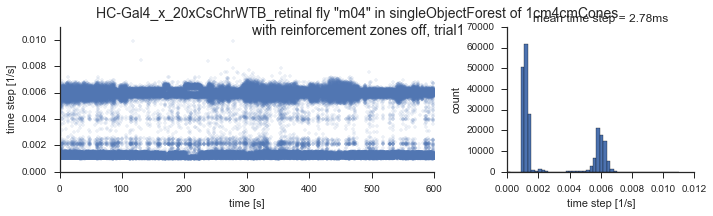

In [59]:
tstpfig = plt.figure(figsize=(10, 3))
gs = gridspec.GridSpec(1, 2, width_ratios=np.hstack((2, 1)))
tstpfig.suptitle(titleString, fontsize=14)
histRange = (0, 0.011)

ax = tstpfig.add_subplot(gs[0])
ax.plot(FOData[0:-2, 0], (FOData[1:-1, 0]-FOData[0:-2, 0]).astype('float'), '.', alpha=0.1)
ax.set_ylim(histRange)
ax.set_xlim((0, time[-1]))
ax.set_xlabel('time [s]')
ax.set_ylabel('time step [1/s]')
myAxisTheme(ax)

ax = tstpfig.add_subplot(gs[1])
ax.hist(FOData[1:-1, 0]-FOData[0:-2, 0], 50, histRange)
ax.set_xlabel('time step [1/s]')
ax.set_ylabel('count')
ax.set_title('mean time step = ' + str(round(np.mean((FOData[1:-1, 0]-FOData[0:-2, 0])*1000.0), 2)) + 'ms')
myAxisTheme(ax)

tstpfig.tight_layout()

makeNestedPlotDirectory(analysisDir, 'timeStepPlot/', 'rZones_'+ rZones + sep)

tstpfig.savefig(analysisDir + 'timeStepPlot/' +  'rZones_'+ rZones + sep
                + FODataFile[0:-4] + '_timeStepPlot_trial' + str(trial) + '.pdf', format='pdf')

#### Plot of walking trace (+ colorbar for time) with object locations

Analysis directory already exists.
Plot directory already exists.


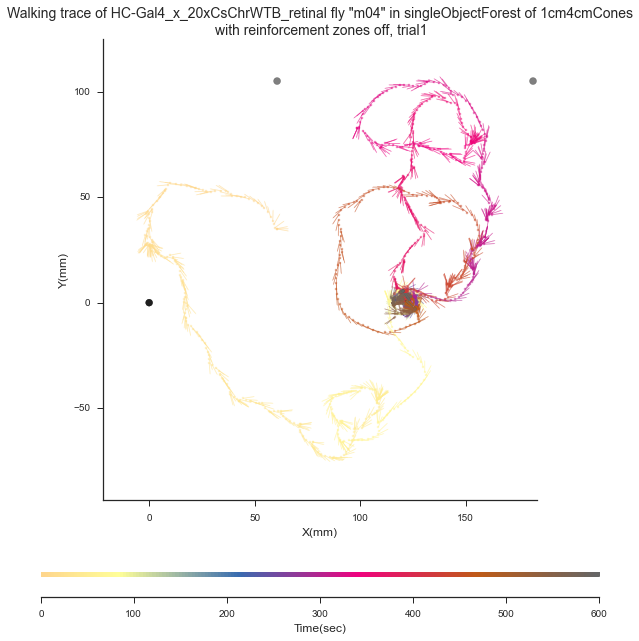

In [60]:
tStart = 0
tEnd = len(FOData[:, 1])
tStep = 72
frameRange = range(tStart, tEnd, tStep)
colMap = 'Accent'
arrowLength = 5

trajfig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=np.hstack((10, 1)))

axTraj = trajfig.add_subplot(gs[0])
axTime = trajfig.add_subplot(gs[1])

plotPosInRange(axTraj, axTime, frameRange, FOData[:, 0], FOData[:, 1], FOData[:, 2], np.pi/180*FOData[:, 5],
               colMap, arrowLength, 0.5, 5)
axTraj.scatter(visibleObjectCoords[:, 0], visibleObjectCoords[:, 1], 50, alpha=0.5,
               facecolor='black', edgecolors='none')
axTraj.scatter(invisibleObjectCoords[4:, 0], invisibleObjectCoords[4:, 1], 50, alpha=0.5,
               facecolors='none', edgecolors='black')
axTraj.set_xlabel(header[1], fontsize=12)
axTraj.set_ylabel(header[2], fontsize=12)
axTraj.set_title('Walking trace of ' + titleString, fontsize=14)
axTraj.set_xlim([max(-650, min(FOData[:, 1]) - 20), min(650, max(FOData[:, 1]) + 20)])
axTraj.set_ylim([max(-650, min(FOData[:, 2]) - 20), min(650, max(FOData[:, 2]) + 20)])
myAxisTheme(axTraj)

axTime.set_xlabel(header[0], fontsize=12)
plt.xlim((0, FOData[-1, 0]))
timeAxisTheme(axTime)

makeNestedPlotDirectory(analysisDir, 'tracePlot/', 'rZones_'+ rZones + sep)

trajfig.savefig(analysisDir + 'tracePlot/' + 'rZones_'+ rZones + sep
                + FODataFile[0:-4] + '_traceObjectPlot_trial' + str(trial) + '.pdf', format='pdf')

#### Visualise strength of optogenetic stimulation

Analysis directory already exists.
Plot directory already exists.


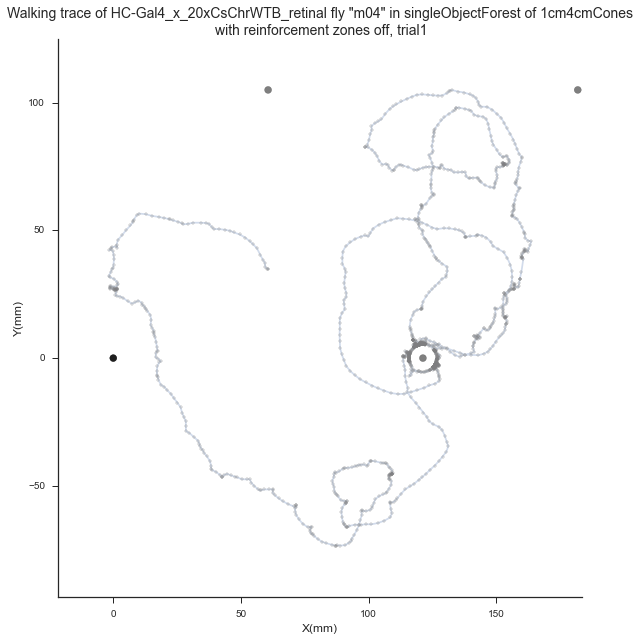

In [61]:
rEvents = FOData[:,11]

tStep = 72
frameRange = range(tStart, tEnd, tStep)

trajRZfig = plt.figure(figsize=(10, 10))
axTraj = trajRZfig.add_subplot(111)

axTraj.scatter(visibleObjectCoords[:, 0], visibleObjectCoords[:, 1], 50, alpha=0.5,
               facecolor='black', edgecolors='none')
axTraj.scatter(invisibleObjectCoords[4:, 0], invisibleObjectCoords[4:, 1], 50, alpha=0.5,
               facecolors='none', edgecolors='black')

plt.plot(FOData[frameRange, 1], FOData[frameRange, 2], marker='.', markerfacecolor='grey',
         markeredgecolor='none', alpha=0.25)

#overlay reinforcement val
axTraj.scatter(FOData[frameRange, 1], FOData[frameRange, 2], s = rEvents[frameRange]*10,
               c = rEvents[frameRange]*10, alpha=0.7,cmap=plt.get_cmap('Reds'))

axTraj.set_xlabel(header[1], fontsize=12)
axTraj.set_ylabel(header[2], fontsize=12)
axTraj.set_title('Walking trace of ' + titleString, fontsize=14)
axTraj.set_xlim([max(-650, min(FOData[:, 1]) - 20), min(650, max(FOData[:, 1]) + 20)])
axTraj.set_ylim([max(-650, min(FOData[:, 2]) - 20), min(650, max(FOData[:, 2]) + 20)])
axTraj.set_aspect('equal')
myAxisTheme(axTraj)

makeNestedPlotDirectory(analysisDir, 'tracePlotRZ/', 'rZones_'+ rZones + sep)

trajRZfig.savefig(analysisDir + 'tracePlotRZ/' + 'rZones_'+ rZones + sep
                + FODataFile[0:-4] + '_traceObjectPlot_trial' + str(trial) + '.pdf', format='pdf')

#### Plot velocity distributions of downs sampled data

Analysis directory already exists.
Plot directory already exists.


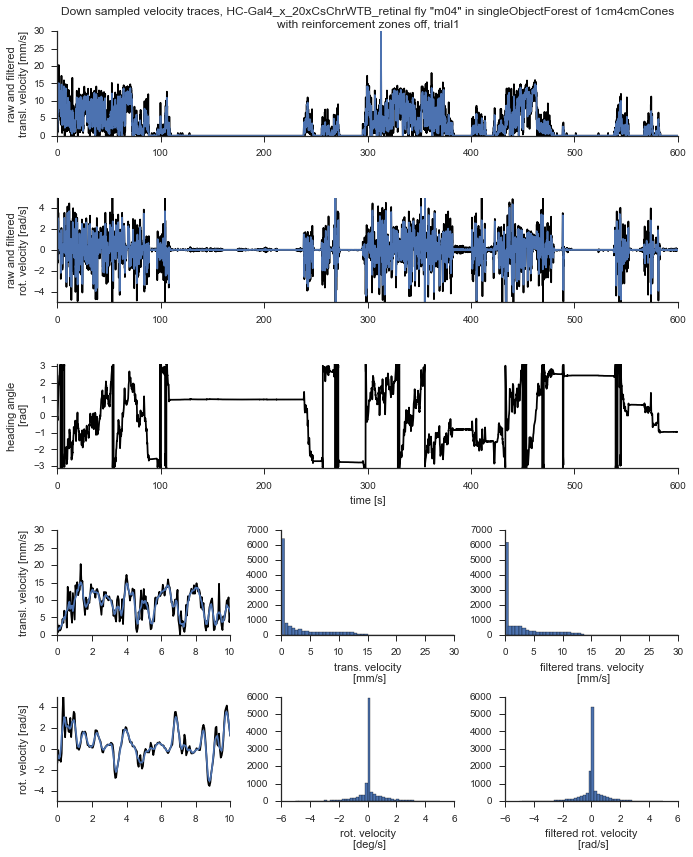

In [62]:
rotLim = (-5, 5)
transLim = (0, 30)
angleLim = (-np.pi, np.pi)
summaryVeloFig_ds = velocitySummaryPlot(time_ds, vTrans_ds, vTransFilt_ds, vRot_ds, vRotFilt_ds, angle_ds, rotLim,
                                        transLim, angleLim, 'Down sampled velocity traces, ' + titleString)

makeNestedPlotDirectory(analysisDir, 'velocityTraces/', 'rZones_'+ rZones + sep)

summaryVeloFig_ds.savefig(analysisDir + 'velocityTraces/' + 'rZones_'+ rZones + sep
                          + FODataFile[0:-4] + '_veloTraces_ds_trial' + str(trial) + '.pdf', format='pdf')

### Collapse traces to single object cell and plot resulting trace
#### Collapse to 'mini-arena' while preserving the global heading

In [63]:
arenaRad = 60 # 1/2 distance between cones
if invisible == 'off':
    objectCoords = np.copy(visibleObjectCoords[0:-3, 0:2])
else:  # use of non-physics, invisible objects allows us to mark virtual object positions in empty arena
    objectCoords = np.copy(invisibleObjectCoords[4:, 0:2])

xPosMA, yPosMA = collapseToMiniArena(FOData[:, 1], FOData[:, 2], arenaRad, objectCoords)

# Compute donw sampled collapsed traces
f_xPosMA = interp1d(time, xPosMA, kind='linear')
f_yPosMA = interp1d(time, yPosMA, kind='linear')

xPosMA_ds = f_xPosMA(time_ds)
yPosMA_ds = f_yPosMA(time_ds)

#### Plot collapsed, down sampled trace

Analysis directory already exists.
Plot directory already exists.


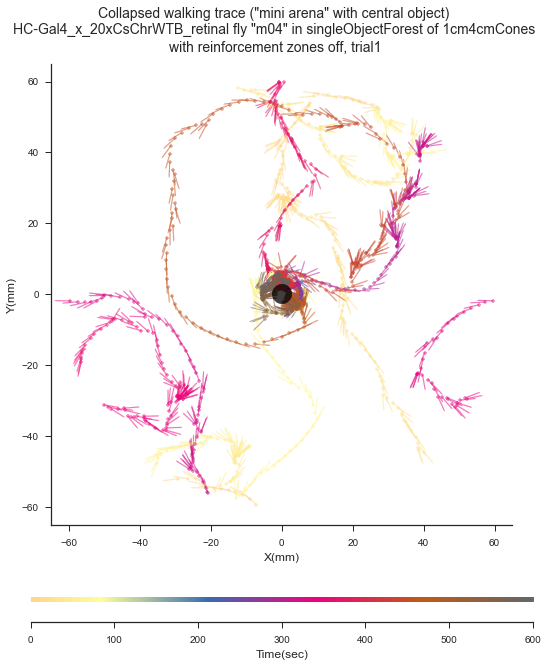

In [64]:
tStart = 0
tEnd = numFrames_ds
tStep = 4
frameRange = range(tStart, tEnd, tStep)
colMap = 'Accent'

colTrFig = plt.figure(figsize=(9, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=np.hstack((10, 1)))

colTrFig.suptitle('Collapsed walking trace ("mini arena" with central object)\n' + titleString, fontsize=14)

axTraj = colTrFig.add_subplot(gs[0])
axTime = colTrFig.add_subplot(gs[1])
plotPosInRange(axTraj, axTime, frameRange, time_ds, xPosMA_ds, yPosMA_ds, angle_ds, colMap, 4, 0.5, 7)

if (invisible == 'off'):
    axTraj.plot(0, 0, marker='o', markersize=20, linestyle='none', alpha=0.75, color='black')
else:
    axTraj.plot(0, 0, marker='o', markersize=20, alpha=0.75, markeredgewidth=0.5, markerfacecolor='None',markeredgecolor='black')

if(rZones=='on'):
    rZoneRange = float(rZone_rOuter - rZone_rInner)
    for zStep in range(1,rZone_max+1):
        circle1=plt.Circle((0,0),(rZoneRange+1)-(zStep*(rZoneRange)/rZone_max) ,color='r',alpha=0.075)
        axTraj.add_artist(circle1)

axTraj.set_xlabel(header[1], fontsize=12)
axTraj.set_ylabel(header[2], fontsize=12)
axTraj.set_ylim([-(arenaRad+5), arenaRad + 5])
axTraj.set_xlim([-(arenaRad+5), arenaRad + 5])
myAxisTheme(axTraj)

axTime.set_xlabel(header[0], fontsize=12)
plt.xlim((0, time_ds[-1]))
timeAxisTheme(axTime)

makeNestedPlotDirectory(analysisDir, 'tracePlotMA/', 'rZones_'+ rZones + sep)

colTrFig.savefig(analysisDir + 'tracePlotMA/' + 'rZones_'+ rZones + sep
                 + FODataFile[0:-4] + '_traceObjectPlot_ds_trial' + str(trial) + '.pdf', format='pdf')

### Compute heading angle relative to closest object (use collapsed coordinates)
#### Compute parameters characterising fly's relationship to object

In [65]:
objLocation = [0, 0]
objDirection, objDistance, gammaFull, gamma, gammaV\
    = relationToObject(time_ds, xPosMA_ds, yPosMA_ds, angle_ds, objLocation)

#### Correlation between optogenetic stimulation and distance to rZone (== objectDistance)

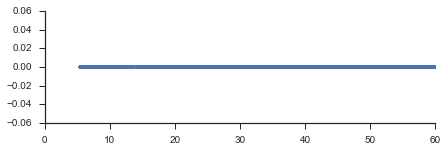

In [66]:
stimFig = plt.figure(figsize=(7,2))

sbplt = stimFig.add_subplot(111)

# downsample rEvents
f_rEvents = interp1d(time,rEvents,kind='linear')
rEvents_ds = f_rEvents(time_ds)

sbplt.plot(objDistance,rEvents_ds,'.')
sbplt.set_xlim(0,arenaRad)
myAxisTheme(sbplt)

#### Visualise effect of turns

In [ ]:
sf = 0
ef = len(xPosMA_ds)
near = 6
far = arenaRad
vTransTH = 2

turnTH = 3*np.std(abs(vRotFilt_ds))
turnMask = (abs(vRotFilt_ds) > turnTH)

selectedRangeDistAll = np.logical_and(objDistance > near, objDistance < far)

selectedRangeDist = np.logical_and(np.logical_and(objDistance > near, objDistance < far), vTrans_ds > vTransTH)
selectedRangeDistTurnWalk = np.logical_and(selectedRangeDist, turnMask)
selectedRangeDistTurn = np.logical_and(np.logical_and(objDistance > near, objDistance < far), turnMask)

In [ ]:
turnEffectFig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(3, 3, height_ratios=np.hstack((1, 1.5, 1.5)), width_ratios=np.hstack((1.5, 1, 1)))

ax0 = turnEffectFig.add_subplot(gs[:, 0])
ax0.plot(xPosMA_ds[selectedRangeDist], yPosMA_ds[selectedRangeDist], '.', color='grey', alpha=0.4)
ax0.plot(xPosMA_ds[selectedRangeDistTurn], yPosMA_ds[selectedRangeDistTurn], '.', color='red', alpha=0.7)
ax0.plot(0, 0, marker='o', markersize=15, linestyle='none', alpha=0.5, color='black')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
ax0.set_xlim((-arenaRad, arenaRad))
ax0.set_ylim((-arenaRad, arenaRad))
ax0.set_aspect('equal')
myAxisTheme(ax0)
ax0.set_title('Effect of turns in ' + flyID + ', trial' + str(trial) +
              '\n percentage turns: ' + str(round(100.0*sum(turnMask)/len(vRotFilt_ds), 2)) + '\n', fontsize=13)

ax = turnEffectFig.add_subplot(gs[0, 1:3])
gammaFullSelect = gammaFull[selectedRangeDistAll]
gammaSelect = gamma[selectedRangeDistAll]
try:
    plt.hist(gammaFullSelect[~np.isnan(gammaFullSelect)], bins=50, color='lightblue', alpha=0.8)
    plt.hist(gammaSelect[~np.isnan(gammaSelect)], bins=50, color='grey', alpha=0.5)
except ValueError:
    print('Not enough values for histogram.')
plt.xlabel('relative heading angle [rad], not filtered for vTrans > ' + str(vTransTH))
plt.ylabel('count')
ax.set_xlim((-np.pi, np.pi))
myAxisTheme(ax)

headingHist = plotVeloHistogram_fancy(gamma[selectedRangeDist], gs[1, 1], (0, np.pi), 'grey', 0.5)
headingHist.set_ylabel('walking filtered\n count (vTrans > ' + str(vTransTH) + ')')

headingHistTurn = plotVeloHistogram_fancy(gamma[selectedRangeDistTurn], gs[2, 1], (0, np.pi), 'red', 0.5)
headingHistTurn.set_ylabel('walking & turn filtered\n count')
headingHistTurn.set_xlabel('heading angle\n [rad]')

rotVHist = plotVeloHistogram_fancy(gammaV[selectedRangeDist], gs[1, 2], (-10, 10), 'grey', 0.5)
rotVHist.set_xlabel('change in heading while walking\n [rad/s]')

rotVHistFilt = plotVeloHistogram_fancy(gammaV[selectedRangeDistTurn], gs[2, 2], (-10, 10), 'red', 0.5)
rotVHistFilt.set_xlabel('change in heading during turn\n [rad/s]')

turnEffectFig.tight_layout()

makeNestedPlotDirectory(analysisDir, 'effectOfTurn/', 'rZones_'+ rZones + sep)

turnEffectFig.savefig(analysisDir + 'effectOfTurn/' + 'rZones_'+ rZones + sep
                      + FODataFile[0:-4] + '_turnHeadingChange_trial' + str(trial) + '.pdf', format='pdf')

### Save position and velocities for future analysis

In [ ]:
toSave = {'time': time_ds,
          'xPos': xPos_ds,
          'yPos': yPos_ds,
          'xPosInMiniarena': xPosMA_ds,
          'yPosInMiniarena': yPosMA_ds,
          'headingAngle': angle_ds,
          'rotVelo': vRot_ds,
          'transVelo': vTrans_ds,
          'objectDistance': objDistance,
          'gammaFull': gammaFull,
          'gamma': gamma}
# Alternatively use numpy array:
# toSave=np.vstack((time_ds,xPos_ds, yPos_ds, xPosMA_ds, yPosMA_ds, angle_ds, vRot_ds,vTrans_ds,objDistance,gamma))

# Save data in this format as *.npy for easy loading..
np.save(expDir + FODataFile[:-4], toSave)